In [10]:
from astropy.io import ascii

import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import cm

import numpy as np
import astropy.units as u

from scipy.interpolate import UnivariateSpline
from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import interp1d
from scipy.interpolate import make_interp_spline, BSpline
import palettable

from code.aux import log_interp1d, data_on_grid, make_grid

In [11]:
pgf_with_rc_fonts = {                      # setup matplotlib to use latex for output
    "pgf.texsystem": "pdflatex",        # change this if using xetex or lautex
    "text.usetex": True,                # use LaTeX to write all text
    "font.family": "sans-serif",
    "font.serif": [],                   # blank entries should cause plots to inherit fonts from the document
    "font.sans-serif": [],
    "font.monospace": [],
    "axes.labelsize": 16,               # LaTeX default is 10pt font.
    "font.size": 14,
    "legend.fontsize": 12,               # Make the legend/label fonts a little smaller
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.top": True,
    "ytick.right": True,
    "pgf.preamble": [
        r"\usepackage[utf8x]{inputenc}",    # use utf8 fonts becasue your computer can handle it :)
        r"\usepackage[T1]{fontenc}",        # plots will be generated using this preamble
        ]
    }

mpl.rcParams.update(pgf_with_rc_fonts)
# full page plot:
figwidth  = 30/ 2.54 

# half page plot:
#figwidth  = 16 / 2.54 

# half page plot:
#figwidth  = 11.6 / 2.54 

# ratio:
ratio = 0.65

image_resolution = 5000

figheight  = ratio * figwidth

from palettable.scientific.sequential import Oslo_9 as colormap

#from palettable.colorbrewer.qualitative import Dark2_7 as colormap
#from palettable.cartocolors.qualitative import Bold_4 as colormap
#from palettable.colorbrewer.qualitative import Set1_4 as colormap


cmap = colormap.get_mpl_colormap()
cmap = mpl.cm.get_cmap("bone").copy()
cmap.set_under("w") # sets background to white

energy_unit = 'TeV'      

In [12]:
experiments = ascii.read("./legend_experiments.ecsv")

In [13]:
import glob
files_all = []
for name in experiments["shortname"]:
    files_all.append(glob.glob("bounds/"+ name +"/*.ecsv"))
files_all = [x for row in files_all for x in row]

In [15]:
import warnings
import pandas as pd

df = pd.DataFrame(columns=('Instrument', 'Target', 'Mode', 'Channel', 'Year', 'Observation time','Title', 'DOI', 'Arxiv', 'File name'))

for i,file in enumerate(files_all):
    filename = file.split("/")[-1][:-5]
    
    inst_name_file = filename.split("_")[0]
    year_file = filename.split("_")[1]
    target_file = filename.split("_")[2]
    mode_file = filename.split("_")[3]
    channel_file = filename.split("_")[4]

    metadata = ascii.read(file).meta
    try:
        assert metadata['instrument'] == inst_name_file
    except:
        warnings.warn("Instrument name not consistent in " + str(file))
    try:
        assert metadata['year'] == year_file
    except:
        warnings.warn("Year not consistent in " + str(file))
    try:
        assert metadata['source'] == target_file
    except:
        warnings.warn("Target name not consistent in " + str(file))
    try:
        assert metadata['channel'] == channel_file
    except:
        warnings.warn("Channel name not consistent in " + str(file))

    df.loc[i] = [metadata['instrument'], metadata['source'], mode_file, metadata['channel'], metadata['year'], 
                 metadata['obs_time'], metadata['reference'], metadata['doi'], metadata['arxiv'], file]

<ipython-input-15-a31494c90b20>:27: UserWarning: Target name not consistent in bounds/magic/magic_2022_combined4_ann_ee.ecsv
  warnings.warn("Target name not consistent in " + str(file))
<ipython-input-15-a31494c90b20>:27: UserWarning: Target name not consistent in bounds/magic/magic_2018_perseuscluster_dec_bb.ecsv
  warnings.warn("Target name not consistent in " + str(file))
<ipython-input-15-a31494c90b20>:27: UserWarning: Target name not consistent in bounds/magic/magic_2022_combined4_ann_bb.ecsv
  warnings.warn("Target name not consistent in " + str(file))
<ipython-input-15-a31494c90b20>:27: UserWarning: Target name not consistent in bounds/magic/magic_2019_gc_dec_bb.ecsv
  warnings.warn("Target name not consistent in " + str(file))
<ipython-input-15-a31494c90b20>:27: UserWarning: Target name not consistent in bounds/magic/magic_2009_willman1_ann_points.ecsv
  warnings.warn("Target name not consistent in " + str(file))
<ipython-input-15-a31494c90b20>:27: UserWarning: Target name not

<ipython-input-15-a31494c90b20>:27: UserWarning: Target name not consistent in bounds/hawc/hawc_2018_multidsph_ann_tt.ecsv
  warnings.warn("Target name not consistent in " + str(file))
<ipython-input-15-a31494c90b20>:27: UserWarning: Target name not consistent in bounds/hawc/hawc_2018_multidsph_ann_tt_notri2.ecsv
  warnings.warn("Target name not consistent in " + str(file))
<ipython-input-15-a31494c90b20>:27: UserWarning: Target name not consistent in bounds/hawc/hawc_2018_multidsph_ann_mumu_notri2.ecsv
  warnings.warn("Target name not consistent in " + str(file))
<ipython-input-15-a31494c90b20>:27: UserWarning: Target name not consistent in bounds/hawc/hawc_2018_multidsph_ann_tautau_notri2.ecsv
  warnings.warn("Target name not consistent in " + str(file))


In [16]:
df

,Instrument,Target,Mode,Channel,Year,Observation time,Title,DOI,Arxiv,File name
0,magic,ursamajor2,ann,WW,2018,94.8h,Indirect dark matter searches in the dwarf sat...,10.1088/1475-7516/2018/03/009,1712.03095,bounds/magic/magic_2018_ursamajor2_ann_WW.ecsv
1,magic,combined,ann,ee,2022,h,Combined searches for dark matter in dwarf sph...,10.1016/j.dark.2021.100912,2111.15009,bounds/magic/magic_2022_combined4_ann_ee.ecsv
2,magic,ursamajor2,ann,mumu,2018,94.8h,Indirect dark matter searches in the dwarf sat...,10.1088/1475-7516/2018/03/009,1712.03095,bounds/magic/magic_2018_ursamajor2_ann_mumu.ecsv
3,magic,segue1,dec,WW,2014,157.9h,Optimized dark matter searches in deep observa...,10.1088/1475-7516/2014/02/008,1312.1535,bounds/magic/magic_2014_segue1_dec_WW.ecsv
4,magic,segue1,dec,tautau,2014,157.9h,Optimized dark matter searches in deep observa...,10.1088/1475-7516/2014/02/008,1312.1535,bounds/magic/magic_2014_segue1_dec_tautau.ecsv
...,...,...,...,...,...,...,...,...,...,...
209,hawc,15 dSph galaxies,ann,bb,2018,507d,Dark Matter Limits From Dwarf Spheroidal Galax...,10.3847/1538-4357/aaa6d8,1706.01277,bounds/hawc/hawc_2018_multidsph_ann_bb.ecsv
210,hawc,15 dSph galaxies,ann,tt,2018,507d,Dark Matter Limits From Dwarf Spheroidal Galax...,10.3847/1538-4357/aaa6d8,1706.01277,bounds/hawc/hawc_2018_multidsph_ann_tt.ecsv
211,hawc,14 dSph galaxies,ann,tt,2018,507d,Dark Matter Limits From Dwarf Spheroidal Galax...,10.3847/1538-4357/aaa6d8,1706.01277,bounds/hawc/hawc_2018_multidsph_ann_tt_notri2....
212,hawc,14 dSph galaxies,ann,mumu,2018,507d,Dark Matter Limits From Dwarf Spheroidal Galax...,10.3847/1538-4357/aaa6d8,1706.01277,bounds/hawc/hawc_2018_multidsph_ann_mumu_notri...


In [79]:
xmin = 2*u.GeV
xmax = 200*u.TeV

In [4]:
x_grid = make_grid(xmin, xmax, npoints=2000, unit=energy_unit, log=True)

In [5]:
channel = 'bb'

data_fermi2020 = ascii.read("bounds/fermi/lat_2020_multidsph_ann_%s_oneD_frequentist.ecsv"%channel)
data_fermi2017 = ascii.read("bounds/fermi/lat_2014_multidsph_ann_%s.ecsv"%channel) 
data_magic = ascii.read("bounds/magic/magic_2022_combined4_ann_%s.ecsv"%channel) 
data_hawc = ascii.read("bounds/hawc/hawc_2017_multidsph_ann_%s.ecsv"%channel) 
#data_hess_fornax = ascii.read("bounds/hess/hess_2012_fornaxcluster_ann_%s_nfwrb02.ecsv"%channel) 
data_magic_lat = ascii.read("bounds/multi-instrument/magic_lat_2016_multidsph_ann_%s.ecsv"%channel) 
data_hess = ascii.read("bounds/hess/hess_2014_sagittarius_ann_%s_NFW.ecsv"%channel) 


legend_channel = ascii.read("legend_experiments.ecsv") 

In [6]:
data_fermi2017

mass,bootes_I,bootes_II,bootes_III,canes_venatici_I,canes_venatici_II,canis_major,carina,coma_berenices,draco,fornax,hercules,leo_I,leo_II,leo_IV,leo_V,pisces_II,sagittarius,sculptor,segue_1,segue_2,sextans,ursa_major_I,ursa_major_II,ursa_minor,willman_1,sigmav
GeV,cm3 / s,cm3 / s,cm3 / s,cm3 / s,cm3 / s,cm3 / s,cm3 / s,cm3 / s,cm3 / s,cm3 / s,cm3 / s,cm3 / s,cm3 / s,cm3 / s,cm3 / s,cm3 / s,cm3 / s,cm3 / s,cm3 / s,cm3 / s,cm3 / s,cm3 / s,cm3 / s,cm3 / s,cm3 / s,cm3 / s
float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
6.0,7.83e-26,nan,nan,8.66e-25,1.18e-24,nan,5.83e-25,4.59e-26,4.87e-26,2.97e-25,1.42e-24,1.57e-24,2.29e-24,5.7e-25,nan,nan,nan,8.9e-26,3.13e-26,nan,4.82e-25,1.11e-25,5.87e-26,3.46e-26,1.22e-25,2.52e-26
10.0,9.41e-26,nan,nan,7.99e-25,1.38e-24,nan,6.87e-25,4.21e-26,4.52e-26,3.49e-25,1.55e-24,1.63e-24,2.09e-24,4.39e-25,nan,nan,nan,1.18e-25,4.36e-26,nan,5.76e-25,1.13e-25,7.36e-26,3.27e-26,1.38e-25,2.9e-26
25.0,1.78e-25,nan,nan,1.4e-24,2.13e-24,nan,9.33e-25,5.86e-26,7.47e-26,6.35e-25,2.95e-24,2.37e-24,2.16e-24,5.16e-25,nan,nan,nan,3.05e-25,9.39e-26,nan,8.54e-25,1.87e-25,1.38e-25,4.75e-26,2.37e-25,5e-26
50.0,3.08e-25,nan,nan,2.88e-24,3e-24,nan,1.08e-24,9.38e-26,1.32e-25,1.09e-24,5.33e-24,3.48e-24,2.16e-24,7.93e-25,nan,nan,nan,6.34e-25,1.8e-25,nan,1.04e-24,3.15e-25,2.17e-25,7.98e-26,3.69e-25,7.91e-26
100.0,6.29e-25,nan,nan,6.1e-24,4.42e-24,nan,1.42e-24,1.73e-25,2.53e-25,2e-24,9.74e-24,5.48e-24,3.06e-24,1.48e-24,nan,nan,nan,1.31e-24,3.62e-25,nan,1.3e-24,5.9e-25,3.43e-25,1.59e-25,6.21e-25,1.34e-25
250.0,1.94e-24,nan,nan,1.8e-23,8.26e-24,nan,3.53e-24,4.65e-25,6.82e-25,5.28e-24,2.32e-23,1.22e-23,7.3e-24,4.17e-24,nan,nan,nan,3.59e-24,9.68e-25,nan,2.52e-24,1.61e-24,6.92e-25,4.65e-25,1.51e-24,3.03e-25
500.0,4.62e-24,nan,nan,4.38e-23,1.67e-23,nan,1.11e-23,1.09e-24,1.62e-24,1.18e-23,4.94e-23,2.62e-23,1.72e-23,1.04e-23,nan,nan,nan,8.18e-24,2.17e-24,nan,5.33e-24,3.87e-24,1.37e-24,1.15e-24,3.4e-24,6.23e-25
1000.0,1.16e-23,nan,nan,1.14e-22,3.9e-23,nan,3.72e-23,2.76e-24,3.95e-24,2.89e-23,1.12e-22,6.32e-23,4.53e-23,2.76e-23,nan,nan,nan,1.94e-23,5.22e-24,nan,1.28e-23,1.01e-23,3.09e-24,2.94e-24,8.29e-24,1.36e-24


In [7]:
fermi_2020_gridded = data_on_grid(data_fermi2020['mass'], data_fermi2020['sigmav'], x_grid, interpolation_kind='quadratic', fill_value = 1e40)
#fermi_2017_gridded = data_on_grid(data_fermi2017['mass'], data_fermi2017['sigmav'], x_grid, interpolation_kind='quadratic', fill_value = 1e40)
magic_gridded = data_on_grid(data_magic['mass'], data_magic['sigmav'], x_grid, interpolation_kind='quadratic', fill_value = 1e40)
hawc_gridded = data_on_grid(data_hawc['mass'], data_hawc['sigmav'], x_grid, interpolation_kind='quadratic', fill_value = 1e40)
magic_lat_gridded = data_on_grid(data_magic_lat['mass'], data_magic_lat['sigmav'], x_grid, interpolation_kind='quadratic', fill_value = 1e40)
hess_gridded = data_on_grid(data_hess['mass'], data_hess['sigmav'], x_grid, interpolation_kind='cubic', fill_value = 1e40)

In [8]:
envelope= []

for i in range(len(x_grid)):
    val1 = fermi_2020_gridded[i].value
    if np.isnan(val1): val1 =1e40
    val2 = hess_gridded[i].value
    if np.isnan(val2): val2 =1e40
    val3 = magic_gridded[i].value
    if np.isnan(val3): val3 =1e40
    val4 = magic_lat_gridded[i].value
    if np.isnan(val4): val4 =1e40
    minvals = [val1, val2, val3, val4]
    envelope.append(0.95*min(minvals))

Text(0, 0.5, '$\\langle\\sigma v \\rangle$ $[\\mathrm{cm^3\\,s^{-1}}]$')

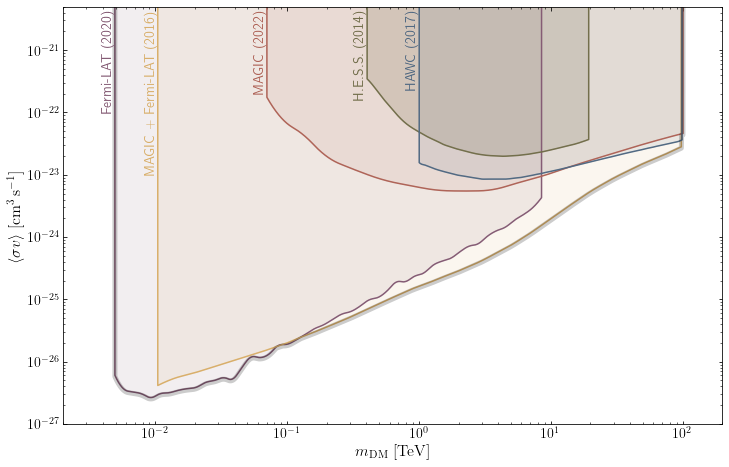

In [9]:

plot_limits = plt.figure(figsize=(figwidth, figheight))

cmap = mpl.colors.ListedColormap(palettable.colorbrewer.qualitative.Dark2_5.mpl_colors)
cmap = mpl.colors.ListedColormap(palettable.cartocolors.qualitative.Antique_5.mpl_colors)
#cmap = mpl.colors.ListedColormap(palettable.wesanderson.Moonrise4_5.mpl_colors)


plt.plot(x_grid, fermi_2020_gridded, color=cmap.colors[0])
plt.plot(x_grid, magic_lat_gridded, color=cmap.colors[1])
plt.plot(x_grid, hess_gridded, color=cmap.colors[3])
plt.plot(x_grid, magic_gridded, color=cmap.colors[2])
plt.plot(x_grid, hawc_gridded, color=cmap.colors[4])


plt.fill_between(x_grid.value, fermi_2020_gridded.value, np.ones(len(x_grid)), alpha=0.1, color=cmap.colors[0])
plt.fill_between(x_grid.value, hess_gridded.value, np.ones(len(x_grid)), alpha=0.2, color=cmap.colors[3])
plt.fill_between(x_grid.value, magic_gridded.value, np.ones(len(x_grid)), alpha=0.1, color=cmap.colors[2])
plt.fill_between(x_grid.value, magic_lat_gridded.value, np.ones(len(x_grid)), alpha=0.1, color=cmap.colors[1])
plt.fill_between(x_grid.value, hawc_gridded.value, np.ones(len(x_grid)), alpha=0.1, color=cmap.colors[4])

plt.plot(x_grid, envelope, linewidth=5, color='k', alpha=0.2)


ymax = 5e-21

plt.text(data_fermi2020['mass'].to(energy_unit)[0].value, 0.9*ymax,  "Fermi-LAT (2020)", horizontalalignment='right', verticalalignment='top', snap=True, color=cmap.colors[0], rotation=90)
plt.text(data_magic_lat['mass'].to(energy_unit)[0].value, 0.9*ymax,  "MAGIC + Fermi-LAT (2016)", horizontalalignment='right', verticalalignment='top', snap=True, color=cmap.colors[1], rotation=90)
plt.text(data_magic['mass'].to(energy_unit)[0].value, 0.9*ymax,  "MAGIC (2022)", horizontalalignment='right', verticalalignment='top', snap=True, color=cmap.colors[2], rotation=90)
plt.text(data_hess['mass'].to(energy_unit)[0].value, 0.9*ymax,  "H.E.S.S. (2014)", horizontalalignment='right', verticalalignment='top', snap=True, color=cmap.colors[3], rotation=90)
plt.text(data_hawc['mass'].to(energy_unit)[0].value, 0.9*ymax,  "HAWC (2017)", horizontalalignment='right', verticalalignment='top', snap=True, color=cmap.colors[4], rotation=90)



plt.xscale('log')
plt.yscale('log')
plt.ylim([1e-27,ymax])
plt.xlim([xmin.to(energy_unit).value, xmax.to(energy_unit).value]);

plt.xlabel(r'$m_{\mathrm{DM}}$ $\mathrm{[' +energy_unit + ']}$');
plt.ylabel(r'$\langle\sigma v \rangle$ $[\mathrm{cm^3\,s^{-1}}]$')


In [ ]:
png_name = "best_limits_ann.png"
plot_limits.savefig(png_name, format='png', dpi=300, bbox_inches="tight")

In [ ]:
cmap.colors[0]

In [ ]:
data_fermi2020['mass'].to(energy_unit)[0].value